In [14]:
import numpy as np
import pandas as pd
from functions import loadMultiParquet, cut, getXSectionBR
from helpersForNN import preprocessMultiClass, scale, unscale
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import mplhep as hep
hep.style.use("CMS")
import glob, re, sys
import math
from applyMultiClass_Hpeak import getPredictions, splitPtFunc

In [15]:
pTClass, nReal, nMC = 2, 400, -1
paths = [
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/Data1A/others",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/GluGluHToBB/others",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-100to200",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-200to400",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-400to600",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-600to800",
            "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/bb_ntuples/flatForGluGluHToBB/ZJets/ZJetsToQQ_HT-800toInf"
            ]

pathToPredictions = "/pnfs/psi.ch/cms/trivcat/store/user/gcelotto/NNpredictions"
# check for which fileNumbers the predictions is available
isMCList = [0, 1,36, 20, 21, 22, 23]
fileNumberList = []
for isMC in isMCList:
    fileNumberProcess = []
    fileNamesProcess = glob.glob(pathToPredictions+"/yMC%d_fn*pt%d*.parquet"%(isMC, pTClass))
    for fileName in fileNamesProcess:
        match = re.search(r'_fn(\d+)_pt', fileName)
        if match:
            fn = match.group(1)
            fileNumberProcess.append(int(fn))
            
        else:
            pass
            #print("Number not found")
    fileNumberList.append(fileNumberProcess)
    print(len(fileNumberProcess), " predictions files for process MC : ", isMC)


# load the files where the prediction is available
dfs, numEventsList, fileNumberList = loadMultiParquet(paths=paths, nReal=nReal, nMC=nMC, columns=['sf', 'dijet_mass', 'dijet_pt', 'jet1_pt', 'jet2_pt','jet1_mass', 'jet2_mass', 'jet3_mass', 'jet1_eta', 'jet2_eta', 'jet1_qgl', 'jet2_qgl', 'dijet_dR', 'dijet_dPhi'], returnNumEventsTotal=True, selectFileNumberList=fileNumberList, returnFileNumberList=True)
pTmin, pTmax, suffix = [[0,-1,'inclusive'], [0, 30, 'lowPt'], [30, 100, 'mediumPt'], [100, -1, 'highPt']][pTClass]    

lengthPreCut = []
for df in dfs:
    lengthPreCut.append(len(df))
dfs = preprocessMultiClass(dfs, pTmin, pTmax, suffix)   # get the dfs with the cut in the pt class
for idx, df in enumerate(dfs):
    print(len(df)/lengthPreCut[idx])


1016  predictions files for process MC :  0
154  predictions files for process MC :  1
1621  predictions files for process MC :  36
162  predictions files for process MC :  20
249  predictions files for process MC :  21
241  predictions files for process MC :  22
210  predictions files for process MC :  23
Looking for a specific list of  1016  files expected
Found 1007 files for process 0
400 files for process 0


Looking for a specific list of  154  files expected
Found 154 files for process 1
154 files for process 1


Looking for a specific list of  1621  files expected
Found 1621 files for process 2
1621 files for process 2


Looking for a specific list of  162  files expected
Found 162 files for process 3
162 files for process 3


Looking for a specific list of  249  files expected
Found 249 files for process 4
249 files for process 4


Looking for a specific list of  241  files expected
Found 241 files for process 5
241 files for process 5


Looking for a specific list of  210  fi

In [16]:
minPt, maxPt = None, None #180, -1
if (minPt is not None) | (maxPt is not None):
    dfs, masks = splitPtFunc(dfs, minPt, maxPt)
    splitPt = True
else:
    masks=None
    splitPt=False
        
W = dfs[0].sf
W_H = dfs[1].sf*getXSectionBR()/numEventsList[1]*nReal*0.774/1017*1000
W_1 = 5.261e+03/numEventsList[2]*dfs[2].sf*nReal*0.774/1017*1000
W_2 = 1012./numEventsList[3]*dfs[3].sf*nReal*0.774/1017*1000
W_3 = 114.2/numEventsList[4]*dfs[4].sf*nReal*0.774/1017*1000
W_4 = 25.34/numEventsList[5]*dfs[5].sf*nReal*0.774/1017*1000
W_5 = 12.99/numEventsList[6]*dfs[6].sf*nReal*0.774/1017*1000
dfs = [dfs[0], dfs[1], pd.concat(dfs[2:])]

W_Z = np.concatenate([W_1, W_2, W_3, W_4, W_5])

In [17]:
YPred_data, YPred_H, YPred_Z100to200, YPred_Z200to400, YPred_Z400to600, YPred_Z600to800, YPred_Z800toInf = getPredictions(fileNumberList, pathToPredictions, splitPt=splitPt, masks=masks, isMC=isMCList, pTClass=pTClass)
YPred_Z = np.concatenate((YPred_Z100to200, YPred_Z200to400, YPred_Z400to600, YPred_Z600to800, YPred_Z800toInf))

In [18]:

mdata=((dfs[0].jet1_pt>10) & (dfs[0].jet2_pt>10))
mH=((dfs[1].jet1_pt>10) & (dfs[1].jet2_pt>10))
mZ=((dfs[2].jet1_pt>10) & (dfs[2].jet2_pt>10))
dfs[0]=dfs[0][mdata]
dfs[1]=dfs[1][mH]
dfs[2]=dfs[2][mZ]
print(len(YPred_H))
print(len(mH))
YPred_H=YPred_H[mH]
YPred_Z=YPred_Z[mZ]
YPred_data=YPred_data[mdata]
W_Z=W_Z[mZ]
W_H=W_H[mH]

310811
310811


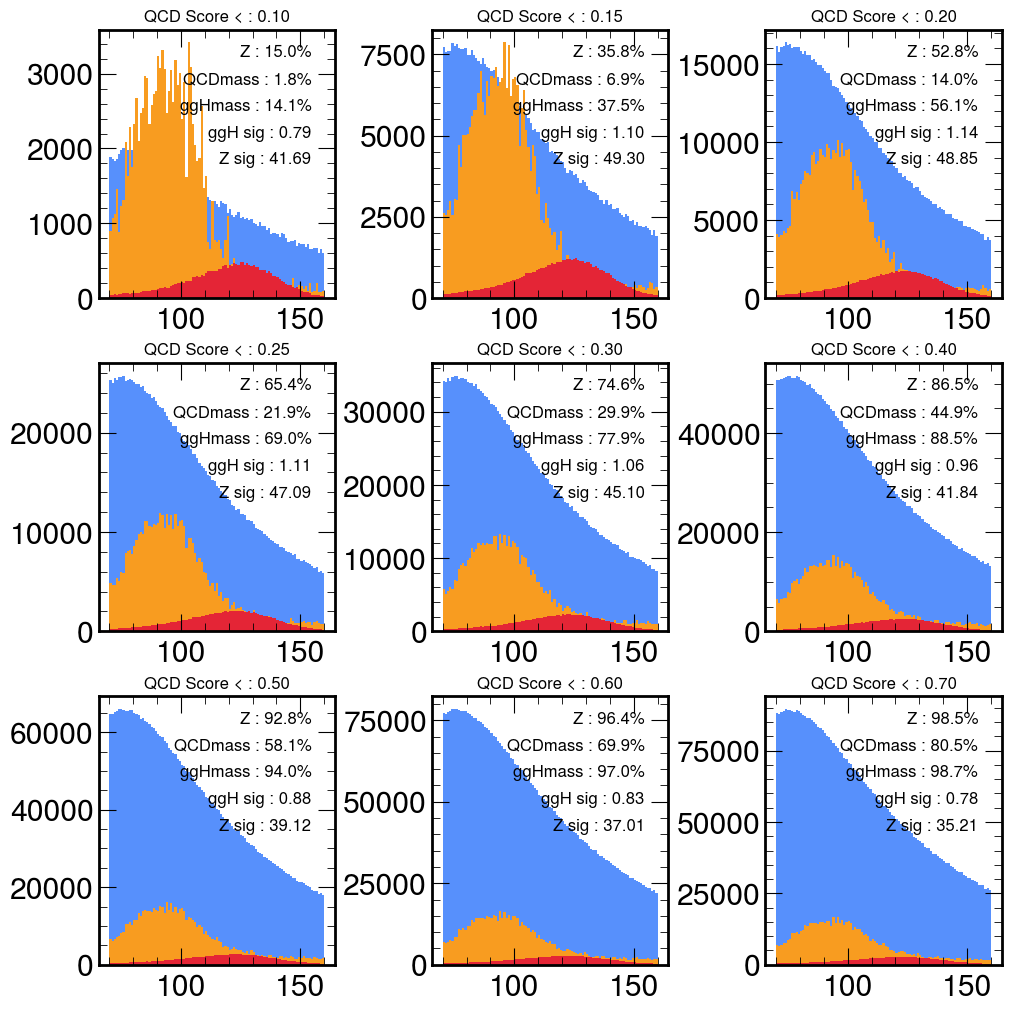

In [19]:
ncols=3
nrows=3
fig, ax = plt.subplots(ncols, nrows, figsize=(10, 10), constrained_layout=True)
bins = np.linspace(70, 160, 100)
massWindowH_data = (dfs[0].dijet_mass>90) & (dfs[0].dijet_mass<170)
massWindowH_H = (dfs[1].dijet_mass>90) & (dfs[1].dijet_mass<170)
massWindowZ_data = (dfs[0].dijet_mass > 60) & (dfs[0].dijet_mass<120)
massWindowZ_Z = (dfs[2].dijet_mass > 60) & (dfs[2].dijet_mass<120)
t = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(ncols):
    for j in range(nrows):
        mask_data = YPred_data[:,0]<t[i*ncols+j]
        mask_Z = YPred_Z[:,0]<t[i*ncols+j]
        mask_H = YPred_H[:,0]<t[i*ncols+j]
        ax[i,j].hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data])[0]
        ax[i,j].hist(dfs[2].dijet_mass[mask_Z], bins=bins, weights=W_Z[mask_Z]*100)[0]
        ax[i,j].hist(dfs[1].dijet_mass[mask_H], bins=bins, weights=W_H[mask_H]*1000)[0]
        ax[i,j].text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(W_Z[mask_Z])/np.sum(W_Z)*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        #ax[i,j].text(x=0.9, y=0.8, s="QCD : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        #ax[i,j].text(x=0.9, y=0.7, s="ggH : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.8, s="QCDmass : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.7, s="ggHmass : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')


        ax[i,j].text(x=0.9, y=0.6, s="ggH sig : %.2f"%(np.sum(W_H[(mask_H) & (massWindowH_H)])/np.sqrt(dfs[0][(mask_data) & (massWindowH_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.5, s="Z sig : %.2f"%(np.sum(W_Z[(mask_Z) & (massWindowZ_Z)])/np.sqrt(dfs[0][(mask_data) & (massWindowZ_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].set_title("QCD Score < : %.2f"%(t[i*ncols+j]), fontsize=12)

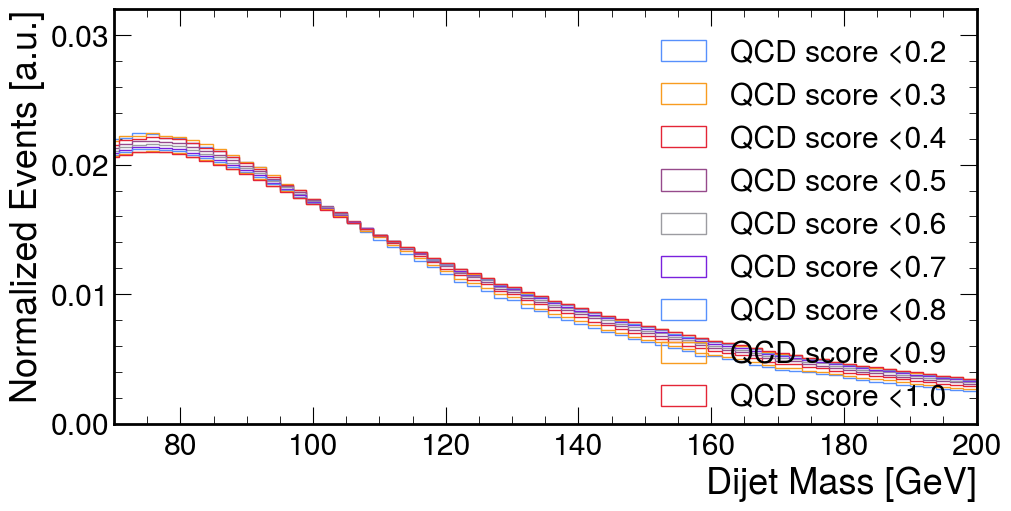

In [20]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)

t = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for i in range(ncols):
    for j in range(nrows):
        mask_data = YPred_data[:,0]<t[i*ncols+j]
        mask_Z = YPred_Z[:,0]<t[i*ncols+j]
        mask_H = YPred_H[:,0]<t[i*ncols+j]
        ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data]/dfs[0].sf[mask_data].sum(), label='QCD score <%.1f'%t[i*ncols+j], histtype=u'step')[0]
ax.set_xlim(70, 200)
ax.set_ylim(0,0.032)
ax.set_ylabel("Normalized Events [a.u.]")
ax.set_xlabel("Dijet Mass [GeV]")
ax.legend()

Text(0, 1, 'Normalized Events [a.u.]')

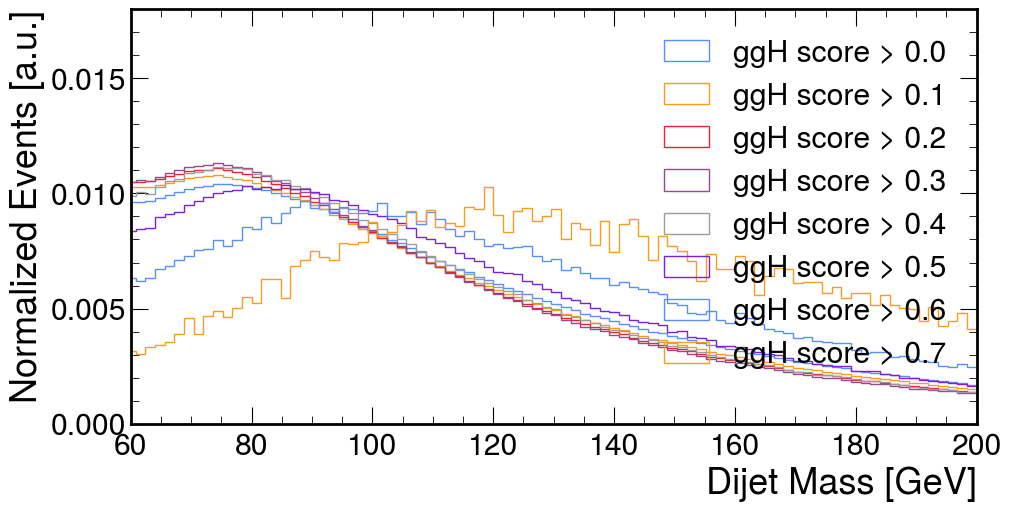

In [21]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(40, 200, 101)

t = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
for i in range(len(t)):
        mask_data = (YPred_data[:,1]>t[i]) 
        mask_Z = YPred_Z[:,1]>t[i]
        mask_H = YPred_H[:,1]>t[i]
        #ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data]/np.sum(dfs[0].sf[mask_data]), label='ggH score >%.1f'%t[i], histtype=u'step')[0]
        ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, density=True, label='ggH score > %.1f'%t[i], histtype=u'step')[0]
ax.set_ylim(0,0.018)
ax.set_xlim(60, 200)
ax.legend()
ax.set_xlabel("Dijet Mass [GeV]")
ax.set_ylabel("Normalized Events [a.u.]")
#ax.set_title("Dijet Mass : ggH score scan")


#fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
#bins = np.linspace(0, 200, 100)
#
##t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
#dijet_threshold=100
#for i in range(len(t)):
#        mask_data = (YPred_data[:,1]>t[i]) & (dfs[0].dijet_pt>dijet_threshold)
#        mask_Z = YPred_Z[:,1]>t[i]
#        mask_H = YPred_H[:,1]>t[i]
#        ax.hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data]/np.sum(dfs[0].sf[mask_data]), label='ggH score >%.1f'%t[i], histtype=u'step')[0]
#ax.legend()

#ax.set_title("Dijet Mass : ggH score scan for dijetPt>%d"%dijet_threshold)

Text(0.5, 1.0, 'Dijet Mass for ggH MC')

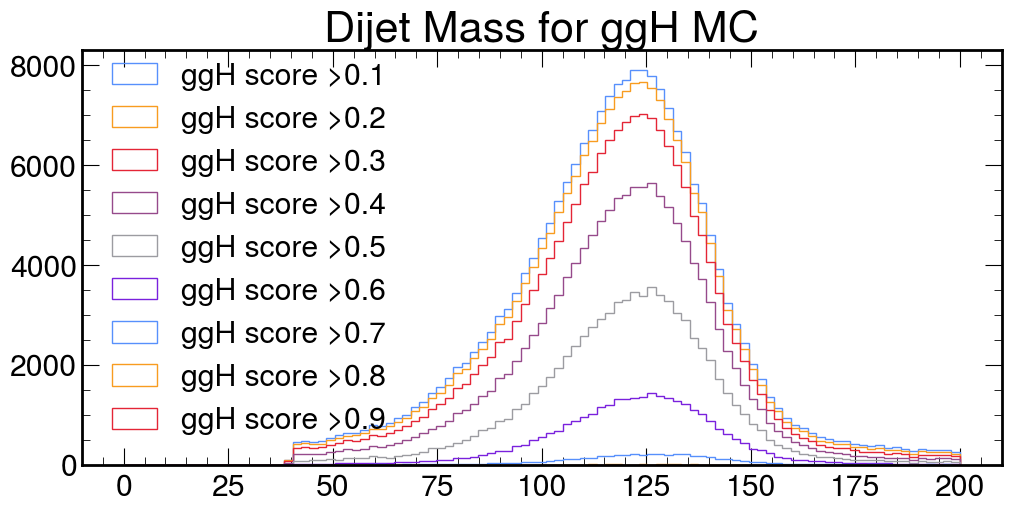

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
bins = np.linspace(0, 200, 100)

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(len(t)):
        mask_data = YPred_data[:,1]>t[i]
        mask_Z = YPred_Z[:,1]>t[i]
        mask_H = YPred_H[:,1]>t[i]
        ax.hist(dfs[1].dijet_mass[mask_H], bins=bins, weights=dfs[1].sf[mask_H], label='ggH score >%.1f'%t[i], histtype=u'step')[0]
ax.legend()
#ax.set_yscale('log')

ax.set_title("Dijet Mass for ggH MC")

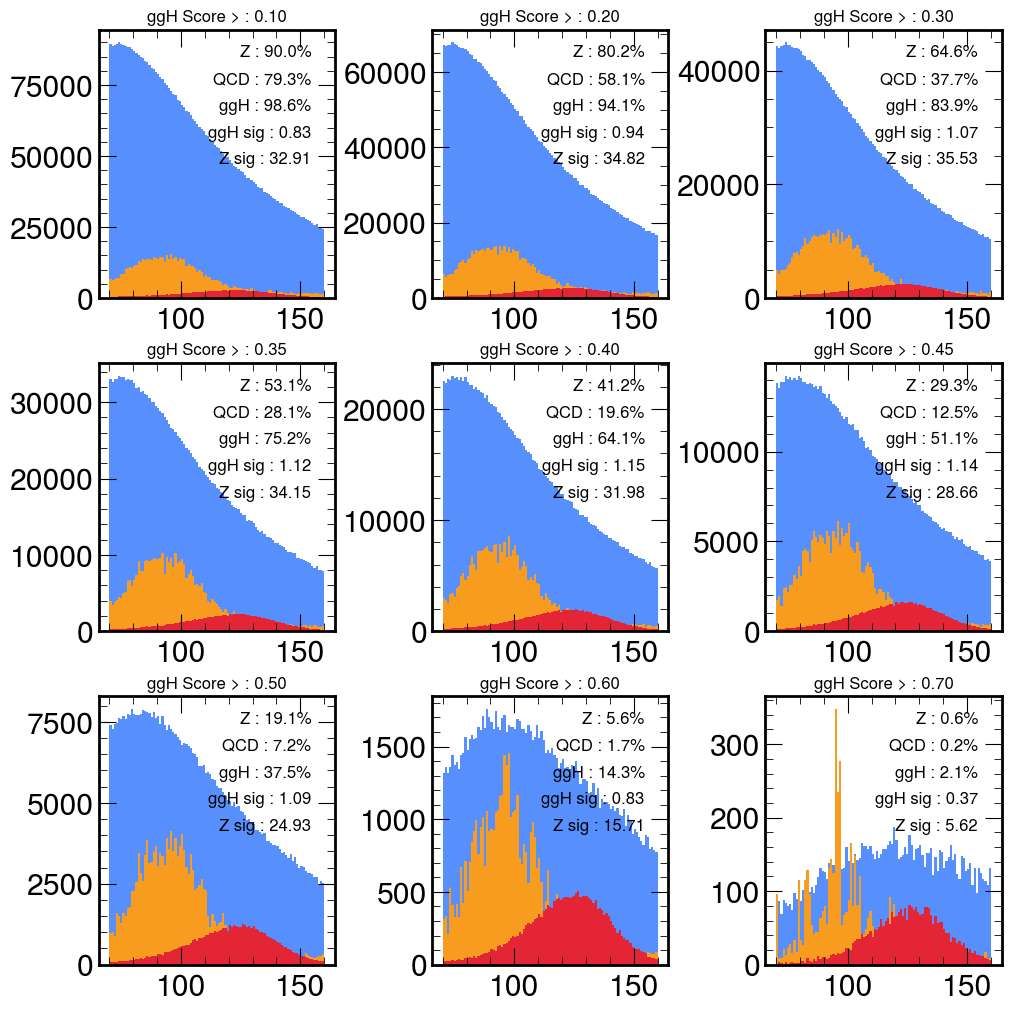

In [23]:
ncols=3
nrows=3
fig, ax = plt.subplots(ncols, nrows, figsize=(10, 10), constrained_layout=True)
bins = np.linspace(70, 160, 100)


massWindowH_data = (dfs[0].dijet_mass>100) & (dfs[0].dijet_mass<150)
massWindowH_H = (dfs[1].dijet_mass>100) & (dfs[1].dijet_mass<150)
massWindowZ_data = (dfs[0].dijet_mass > 60) & (dfs[0].dijet_mass<120)
massWindowZ_Z = (dfs[2].dijet_mass > 60) & (dfs[2].dijet_mass<120)

t = [0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(ncols):
    for j in range(nrows):

        mask_data = (YPred_data[:,1]>t[i*ncols+j]) 
        mask_H = (YPred_H[:,1]>t[i*ncols+j]) 
        mask_Z = (YPred_Z[:,1]>t[i*ncols+j]) 
        ax[i,j].hist(dfs[0].dijet_mass[mask_data], bins=bins, weights=dfs[0].sf[mask_data])[0]
        ax[i,j].hist(dfs[2].dijet_mass[mask_Z], bins=bins, weights=W_Z[mask_Z]*100)[0]
        ax[i,j].hist(dfs[1].dijet_mass[mask_H], bins=bins, weights=W_H[mask_H]*1000)[0]

        ax[i,j].text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(W_Z[mask_Z])/np.sum(W_Z)*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.8, s="QCD : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.7, s="ggH : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.6, s="ggH sig : %.2f"%(np.sum(W_H[(mask_H) & (massWindowH_H)])/np.sqrt(dfs[0][(mask_data) & (massWindowH_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].text(x=0.9, y=0.5, s="Z sig : %.2f"%(np.sum(W_Z[(mask_Z) & (massWindowZ_Z)])/np.sqrt(dfs[0][(mask_data) & (massWindowZ_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax[i,j].transAxes, fontsize=12, ha='right')
        ax[i,j].set_title("ggH Score > : %.2f"%(t[i*ncols+j]), fontsize=12)

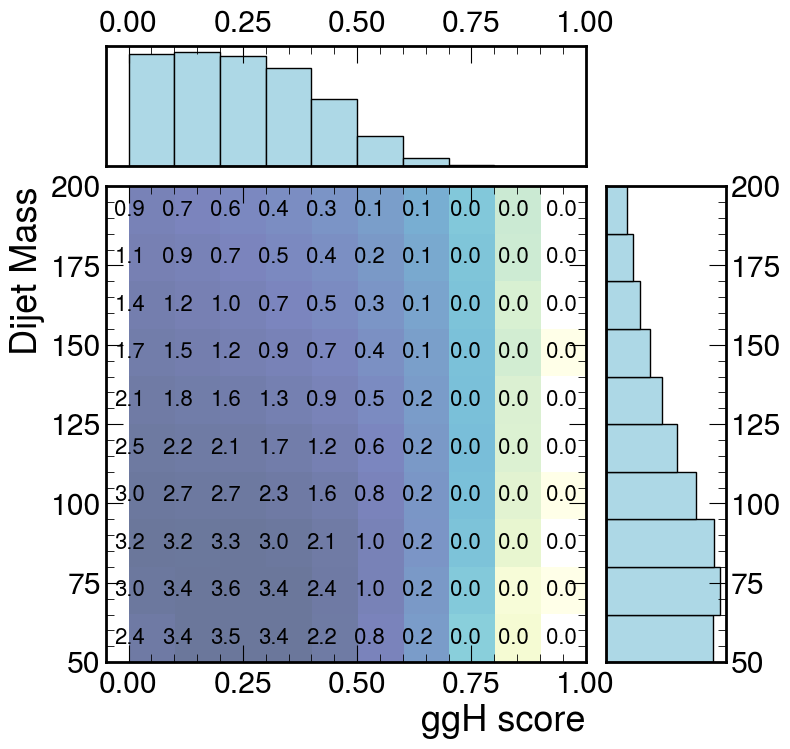

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
x_bins, y_bins = np.linspace(0, 1, 11), np.linspace(50, 200, 11)
fig, ax_main = plt.subplots(figsize=(8, 8))
divider = make_axes_locatable(ax_main)
ax_top = divider.append_axes("top", 1.2, pad=0.2, sharex=ax_main)
ax_right = divider.append_axes("right", 1.2, pad=0.2, sharey=ax_main)


xvar = YPred_data[:,1]
yvar = dfs[0].dijet_mass
# Plot the 2D histogram in the main axes
hist, x_edges, y_edges = np.histogram2d(x=xvar, y=yvar, bins=[x_bins, y_bins])
ax_main.imshow(hist.T, origin='lower', extent=(x_bins.min(), x_bins.max(), y_bins.min(), y_bins.max()), aspect='auto', cmap='YlGnBu', alpha=0.6, norm=LogNorm())
hist=hist/np.sum(hist)*100
for y in range(len(y_bins)-1):
    for x in range(len(x_bins)-1):
        ax_main.text((x+0.5)/(len(y_bins)-1) , (y+0.5)/(len(y_bins)-1) , '%.1f' % hist[x, y],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=16,
                transform=ax_main.transAxes

                )
ax_main.set_xlabel("ggH score")
ax_main.set_ylabel("Dijet Mass")

# Plot the marginalized histogram on top
ax_top.hist(xvar, bins=x_bins, color='lightblue', edgecolor='black')
ax_top.set_xlim(ax_main.get_xlim())
ax_top.set_yticks([])
ax_top.xaxis.tick_top()

# Plot the marginalized histogram on the right
ax_right.hist(yvar, bins=y_bins, color='lightblue', edgecolor='black', orientation='horizontal')#lightcoral
ax_right.set_ylim(ax_main.get_ylim())
ax_right.set_xticks([])
ax_right.yaxis.tick_right()

### Hyp: ggH score > 0.3 as good compromise between shaping and significance
Now scan on QCD score

In [25]:
def sig(t_qcd, t_H):
    massWindowH_data = (dfs[0].dijet_mass>100) & (dfs[0].dijet_mass<150)
    massWindowH_H = (dfs[1].dijet_mass>100) & (dfs[1].dijet_mass<150)
    massWindowZ_data = (dfs[0].dijet_mass > 60) & (dfs[0].dijet_mass<120)
    massWindowZ_Z = (dfs[2].dijet_mass > 60) & (dfs[2].dijet_mass<120)
    mask_data = YPred_data[:,1]>t_H
    mask_H = YPred_H[:,1]>t_H
    mask_Z = YPred_Z[:,1]>t_H
    mask_data = (mask_data) & (YPred_data[:,0]<t_qcd)
    mask_H = (mask_H) & (YPred_H[:,0]<t_qcd)
    mask_Z = (mask_Z) & (YPred_Z[:,0]<t_qcd)
    sig = np.sum(W_H[(mask_H) & (massWindowH_H)])/np.sqrt(dfs[0][(mask_data) & (massWindowH_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)
    return sig

maxt_qcd, maxt_H = -1, -1
    
pbounds = {
        't_qcd': (0.1, .5),
        't_H': (0.1, .5)}
optimizer = BayesianOptimization(
f=sig,
pbounds=pbounds,
verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
random_state=1,
allow_duplicate_points=True
)
    
optimizer.maximize(
    init_points=10,
    n_iter=50,
)

maxt_qcd=optimizer.max["params"]["t_qcd"]
maxt_H=optimizer.max["params"]["t_H"]
print("significance in mass region after cut : %.2f"%sig(maxt_qcd, maxt_H))

|   iter    |  target   |    t_H    |   t_qcd   |
-------------------------------------------------
| 1         | 1.118     | 0.2668    | 0.3881    |
| 2         | 1.228     | 0.1       | 0.2209    |
| 3         | 1.151     | 0.1587    | 0.1369    |
| 4         | 1.224     | 0.1745    | 0.2382    |
| 5         | 1.174     | 0.2587    | 0.3155    |
| 6         | 1.129     | 0.2677    | 0.3741    |
| 7         | 1.03      | 0.1818    | 0.4512    |
| 8         | 1.075     | 0.111     | 0.3682    |
| 9         | 1.171     | 0.2669    | 0.3235    |
| 10        | 1.243     | 0.1562    | 0.1792    |
| 11        | 1.27      | 0.3044    | 0.1994    |
| 12        | 1.241     | 0.4008    | 0.1975    |
| 13        | 1.192     | 0.2553    | 0.2957    |
| 14        | 0.8348    | 0.361     | 0.1       |
| 15        | 1.205     | 0.4097    | 0.286     |
| 16        | 1.103     | 0.5       | 0.2228    |
| 17        | 1.252     | 0.3434    | 0.2447    |
| 18        | 1.089     | 0.5       | 0.5       |


8695.070515310957
46659812.8372093


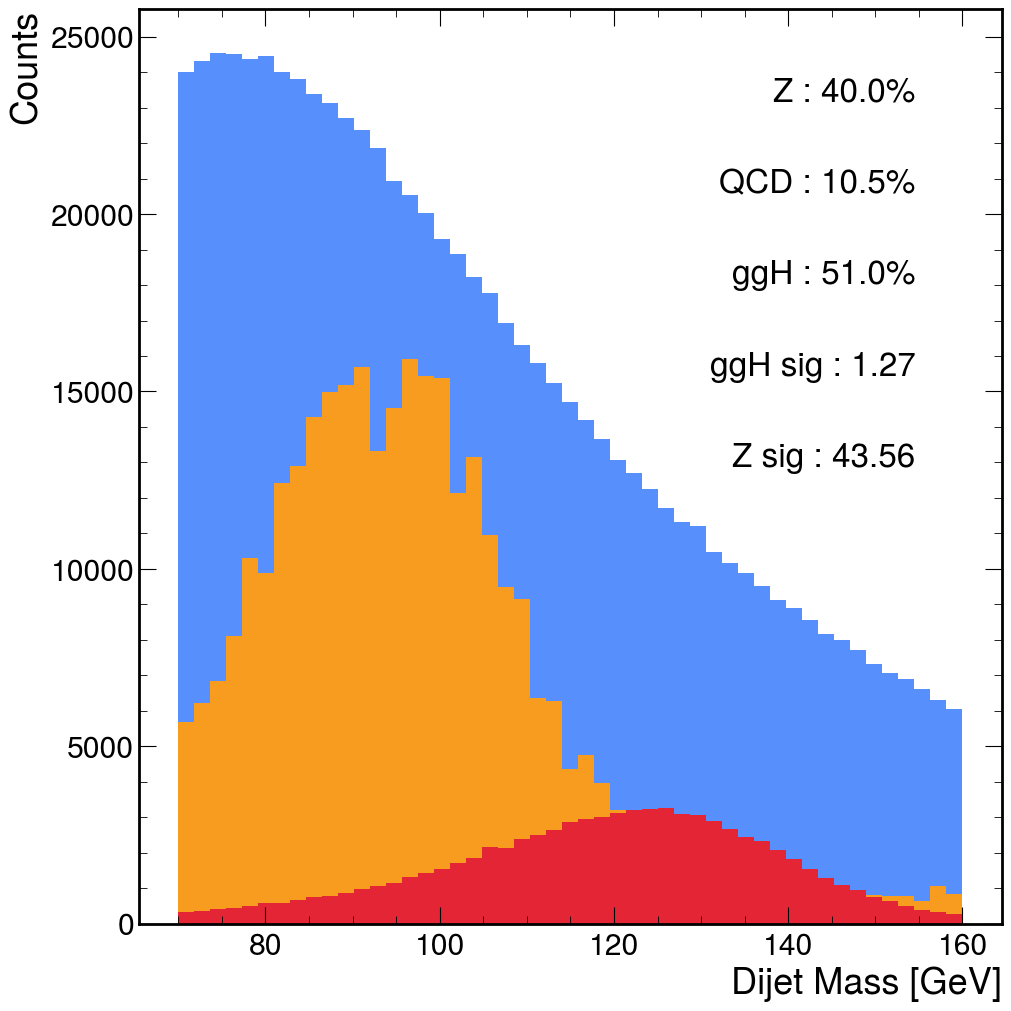

In [26]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
bins = np.linspace(70, 160, 50)

massWindowH_data = (dfs[0].dijet_mass>100) & (dfs[0].dijet_mass<150)
massWindowH_H = (dfs[1].dijet_mass>100) & (dfs[1].dijet_mass<150)
massWindowZ_data = (dfs[0].dijet_mass > 60) & (dfs[0].dijet_mass<120)
massWindowZ_Z = (dfs[2].dijet_mass > 60) & (dfs[2].dijet_mass<120)

mask_data = (YPred_data[:,1]>maxt_H) & (YPred_data[:,0]<maxt_qcd) 
mask_H = (YPred_H[:,1]>maxt_H) & (YPred_H[:,0]<maxt_qcd)
mask_Z = (YPred_Z[:,1]>maxt_H) & (YPred_Z[:,0]<maxt_qcd)
ax.hist(dfs[0].dijet_mass[mask_data],   bins=bins,    weights = dfs[0].sf[mask_data])[0]
ax.hist(dfs[2].dijet_mass[mask_Z],      bins=bins,       weights = W_Z[mask_Z]*100)[0]
ax.hist(dfs[1].dijet_mass[mask_H],      bins=bins,       weights = W_H[mask_H]*1000)[0]

ax.text(x=0.9, y=0.9, s="Z : %.1f%%"%(np.sum(W_Z[mask_Z])/np.sum(W_Z)*100), transform=ax.transAxes, fontsize=24, ha='right')
ax.text(x=0.9, y=0.8, s="QCD : %.1f%%"%(dfs[0].sf[mask_data].sum()/dfs[0].sf.sum()*100), transform=ax.transAxes, fontsize=24, ha='right')
ax.text(x=0.9, y=0.7, s="ggH : %.1f%%"%(dfs[1].sf[mask_H].sum()/dfs[1].sf.sum()*100), transform=ax.transAxes, fontsize=24, ha='right')
ax.text(x=0.9, y=0.6, s="ggH sig : %.2f"%(np.sum(W_H[(mask_H) & (massWindowH_H)])/np.sqrt(dfs[0][(mask_data) & (massWindowH_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax.transAxes, fontsize=24, ha='right')
ax.text(x=0.9, y=0.5, s="Z sig : %.2f"%(np.sum(W_Z[(mask_Z) & (massWindowZ_Z)])/np.sqrt(dfs[0][(mask_data) & (massWindowZ_data)].sf.sum()) *np.sqrt(41.6/0.774*1017/nReal)), transform=ax.transAxes, fontsize=24, ha='right')
ax.set_xlabel("Dijet Mass [GeV]")
ax.set_ylabel("Counts")


print(W_H[(mask_H) & (massWindowH_H)].sum()*41.6/0.774*1017/nReal)
print(dfs[0][(mask_data) & (massWindowH_data)].sf.sum()*41.6/0.774*1017/nReal)
#ax.set_title("ggH Score > : %.2f"%(0.34), fontsize=12)